## **Network Analysis Email-Eu_core Network**

Jaringan ini dibuat menggunakan data email dari sebuah institusi riset besar di Eropa. Email yang tercatat hanya mencakup komunikasi antaranggota institusi (inti) dan tidak termasuk pesan masuk atau keluar ke/dari pihak eksternal. Dataset ini juga menyertakan informasi keanggotaan komunitas "ground-truth" untuk setiap node. Setiap individu tergabung dalam salah satu dari 42 departemen di institusi riset tersebut.

**Install Dependencies**

In [4]:
!pip install networkx pandas numpy plotly matplotlib powerlaw seaborn scipy python-louvain pyvis

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**Import Libraries**

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import powerlaw
import seaborn as sns
import scipy.stats as stats
import community as community_louvain
import gzip

**Visualisasi Network**

In [6]:
# Baca edges
def read_edges(filename):
    edges = []
    with gzip.open(filename, 'rt') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                source = int(parts[0])
                target = int(parts[1])
                edges.append((source, target))
    return edges

# Baca edges dan departments
edges = read_edges("email-Eu-core.txt.gz")
departments = pd.read_csv("email-Eu-core-department-labels.txt.gz", sep=" ", header=None, names=["node", "department"])

# Membuat Directed Graph
DG = nx.DiGraph(edges)

# Menambahkan atribut department
dept_dict = dict(zip(departments['node'], departments['department']))
nx.set_node_attributes(DG, dept_dict, 'department')

# Fungsi untuk visualisasi network interaktif
def visualize_network(G, title="Email Network Visualization"):
    # Menggunakan spring layout untuk posisi node
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Tambahkan seed untuk reproduksibilitas
    
    # Ekstrak koordinat
    x_nodes = [pos[node][0] for node in G.nodes()]
    y_nodes = [pos[node][1] for node in G.nodes()]
    
    # Warna berdasarkan departemen
    departments = list(nx.get_node_attributes(G, 'department').values())
    unique_departments = list(set(departments))
    color_map = px.colors.qualitative.Set3
    
    # Membuat node colors
    node_colors = [color_map[unique_departments.index(dept) % len(color_map)] for dept in departments]
    
    # Membuat edge traces
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_trace = go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            color=node_colors,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Departments',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))
    
    # Tambahkan informasi node
    node_trace.text = [f"Node {node}<br>Department: {dept_dict.get(node, 'Unknown')}" for node in G.nodes()]
    
    # Layout
    layout = go.Layout(
        title=title,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    
    # Gabungkan trace
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    
    return fig

# Visualisasi network keseluruhan
full_network_fig = visualize_network(DG, "Full Email Network (Directed)")
full_network_fig.show()

# Analisis tambahan
print(f"Total Nodes: {DG.number_of_nodes()}")
print(f"Total Edges: {DG.number_of_edges()}")
print(f"Network Density: {nx.density(DG)}")

Total Nodes: 1005
Total Edges: 25571
Network Density: 0.025342411448732432


In [25]:
# Fungsi untuk zoom ke subgraph
def zoom_subgraph(G, department):
    # Filter nodes dari departemen tertentu
    dept_nodes = [n for n, d in G.nodes(data=True) if d.get('department') == department]
    subgraph = G.subgraph(dept_nodes)
    
    return visualize_network(subgraph, f"Subgraph for Department {department}")

# Contoh zoom ke salah satu departemen
first_department = list(set(departments['department']))[0]
dept_subgraph_fig = zoom_subgraph(DG, first_department)
dept_subgraph_fig.show()

# Tambahan: Distribusi Departemen
dept_distribution = departments['department'].value_counts().sort_values(ascending=False)
print("\nDistribusi Nodes per Departemen:")
for dept, count in dept_distribution.items():
    print(f"{dept}: {count} nodes")


Distribusi Nodes per Departemen:
4: 109 nodes
14: 92 nodes
1: 65 nodes
21: 61 nodes
15: 55 nodes
7: 51 nodes
0: 49 nodes
10: 39 nodes
17: 35 nodes
9: 32 nodes
11: 29 nodes
19: 29 nodes
6: 28 nodes
23: 27 nodes
13: 26 nodes
16: 25 nodes
22: 25 nodes
36: 22 nodes
8: 19 nodes
5: 18 nodes
37: 15 nodes
20: 14 nodes
35: 13 nodes
38: 13 nodes
34: 13 nodes
3: 12 nodes
27: 10 nodes
2: 10 nodes
26: 9 nodes
32: 9 nodes
28: 8 nodes
31: 8 nodes
24: 6 nodes
25: 6 nodes
29: 5 nodes
30: 4 nodes
40: 4 nodes
12: 3 nodes
39: 3 nodes
41: 2 nodes
18: 1 nodes
33: 1 nodes


**Pyvis Visualization**

In [52]:
import gzip
import pandas as pd
import networkx as nx
from pyvis.network import Network
import colorsys
import random
import matplotlib.colors as mcolors  # Ensure you have this import for color conversion

def read_edges(filename):
    edges = []
    with gzip.open(filename, 'rt') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                source = int(parts[0])
                target = int(parts[1])
                edges.append((source, target))
    return edges

def generate_distinct_colors(num_colors):
    """
    Generate a list of distinct colors using HSV color space with more variation
    """
    def hsv_to_hex(h, s, v):
        return mcolors.rgb2hex(colorsys.hsv_to_rgb(h, s, v))
    
    colors = []
    for i in range(num_colors):
        # Spread hue more evenly and add more saturation variation
        hue = (i * 0.618033988749895) % 1.0  # Golden ratio method for more uniform color spread
        saturation = 0.7 + (i % 3) * 0.15  # Slight saturation variation
        value = 0.85 + (i % 2) * 0.1  # Slight value variation
        
        color = hsv_to_hex(hue, saturation, value)
        colors.append(color)
    
    return colors

def improved_network_visualization(G, dept_dict, num_clusters=4):
    """
    Improved network visualization with unique color per department across clusters
    """
    # Dapatkan daftar departemen unik
    unique_departments = list(set(dept_dict.values()))
    
    # Generate warna unik untuk setiap departemen
    department_colors = generate_distinct_colors(len(unique_departments))
    
    # Buat pemetaan departemen ke warna
    dept_color_map = dict(zip(unique_departments, department_colors))
    
    # Create a mapping of departments to clusters
    department_to_cluster = {}
    for i, department in enumerate(unique_departments):
        cluster_index = i % num_clusters
        department_to_cluster[department] = cluster_index
    
    # Group nodes by cluster
    cluster_groups = {i: [] for i in range(num_clusters)}
    for node, department in dept_dict.items():
        cluster_index = department_to_cluster[department]
        cluster_groups[cluster_index].append(node)
    
    # Create a visualization for each cluster
    for cluster_idx, cluster_nodes in cluster_groups.items():
        # Create subgraph for this cluster
        cluster_subgraph = G.subgraph(cluster_nodes)
        
        # Create Pyvis Network (undirected)
        net = Network(
            height="800px", 
            width="100%", 
            notebook=True, 
            directed=False,
            bgcolor="#f5f5f5"  # Light gray background
        )
        
        # Add nodes with size based on degree and color by department
        for node in cluster_nodes:
            node_degree = G.degree(node)
            node_size = min(max(5, node_degree * 2), 30)  # Adaptive node size
            
            # Dapatkan warna untuk departemen node ini
            department = dept_dict.get(node, "Unknown Department")
            node_color = dept_color_map.get(department, "#CCCCCC")  # Default abu-abu jika departemen tidak ditemukan
            
            net.add_node(
                node,
                title=f"Node: {node}\nDegree: {node_degree}\nDepartment: {department}",
                color=node_color,
                size=node_size,
                label=str(node)
            )
        
        # Add edges within the cluster (undirected)
        for source, target in cluster_subgraph.edges():
            net.add_edge(source, target, width=1, color='#000000')  # Hitam
        
        # Physics configuration
        net.set_options("""
        var options = {
          "physics": {
            "forceAtlas2Based": {
              "gravitationalConstant": -50,
              "centralGravity": 0.01,
              "springLength": 100,
              "springConstant": 0.08,
              "damping": 0.2,
              "avoidOverlap": 0.5
            },
            "solver": "forceAtlas2Based",
            "maxVelocity": 50,
            "minVelocity": 1,
            "timestep": 0.5
          },
          "interaction": {
            "navigationButtons": true,
            "hover": true,
            "zoomView": true
          }
        }
        """)
        
        # Save visualization
        filename = f"network_cluster_{cluster_idx + 1}.html"
        net.show(filename)
        
        # Print cluster statistics
        print(f"Cluster {cluster_idx +1}:")
        print(f"  Nodes: {len(cluster_nodes)}")
        print(f"  Edges: {len(cluster_subgraph.edges())}")

# Usage
# Read edges and departments
edges = read_edges("email-Eu-core.txt.gz")
departments = pd.read_csv("email-Eu-core-department-labels.txt.gz", sep=" ", header=None, names=["node", "department"])

# Create Directed Graph
DG = nx.DiGraph(edges)

# Add department attributes
dept_dict = dict(zip(departments['node'], departments['department']))
nx.set_node_attributes(DG, dept_dict, 'department')

# Call the visualization function
improved_network_visualization(DG, dept_dict)

network_cluster_1.html
Cluster 1:
  Nodes: 268
  Edges: 4021
network_cluster_2.html
Cluster 2:
  Nodes: 266
  Edges: 3041
network_cluster_3.html
Cluster 3:
  Nodes: 234
  Edges: 3081
network_cluster_4.html
Cluster 4:
  Nodes: 237
  Edges: 2352


Visualisasi dibagi menjadi 4 kluster dan menjadi 4 html berbeda tergantung dari Node dengan derajat dan betweenness centrality tertinggi

##  **Perhitungan network‘s metrics**

**Centrality Measures: Degree, Betweenness, Closeness, Eigen, PageRank**


Top 10 Nodes - Degree Centrality:
Node 160: Value = 0.5438, Department: 36
Node 121: Value = 0.3775, Department: 36
Node 107: Value = 0.3715, Department: 36
Node 62: Value = 0.3675, Department: 36
Node 86: Value = 0.3546, Department: 36
Node 82: Value = 0.3466, Department: 36
Node 434: Value = 0.3068, Department: 34
Node 183: Value = 0.3008, Department: 4
Node 5: Value = 0.2789, Department: 25
Node 129: Value = 0.2739, Department: 4

Top 10 Nodes - In Degree Centrality:
Node 160: Value = 0.2112, Department: 36
Node 62: Value = 0.1783, Department: 36
Node 107: Value = 0.1683, Department: 36
Node 121: Value = 0.1564, Department: 36
Node 86: Value = 0.1534, Department: 36
Node 434: Value = 0.1504, Department: 34
Node 183: Value = 0.1424, Department: 4
Node 129: Value = 0.1384, Department: 4
Node 64: Value = 0.1355, Department: 25
Node 128: Value = 0.1315, Department: 5

Top 10 Nodes - Out Degree Centrality:
Node 160: Value = 0.3327, Department: 36
Node 82: Value = 0.2261, Department: 36


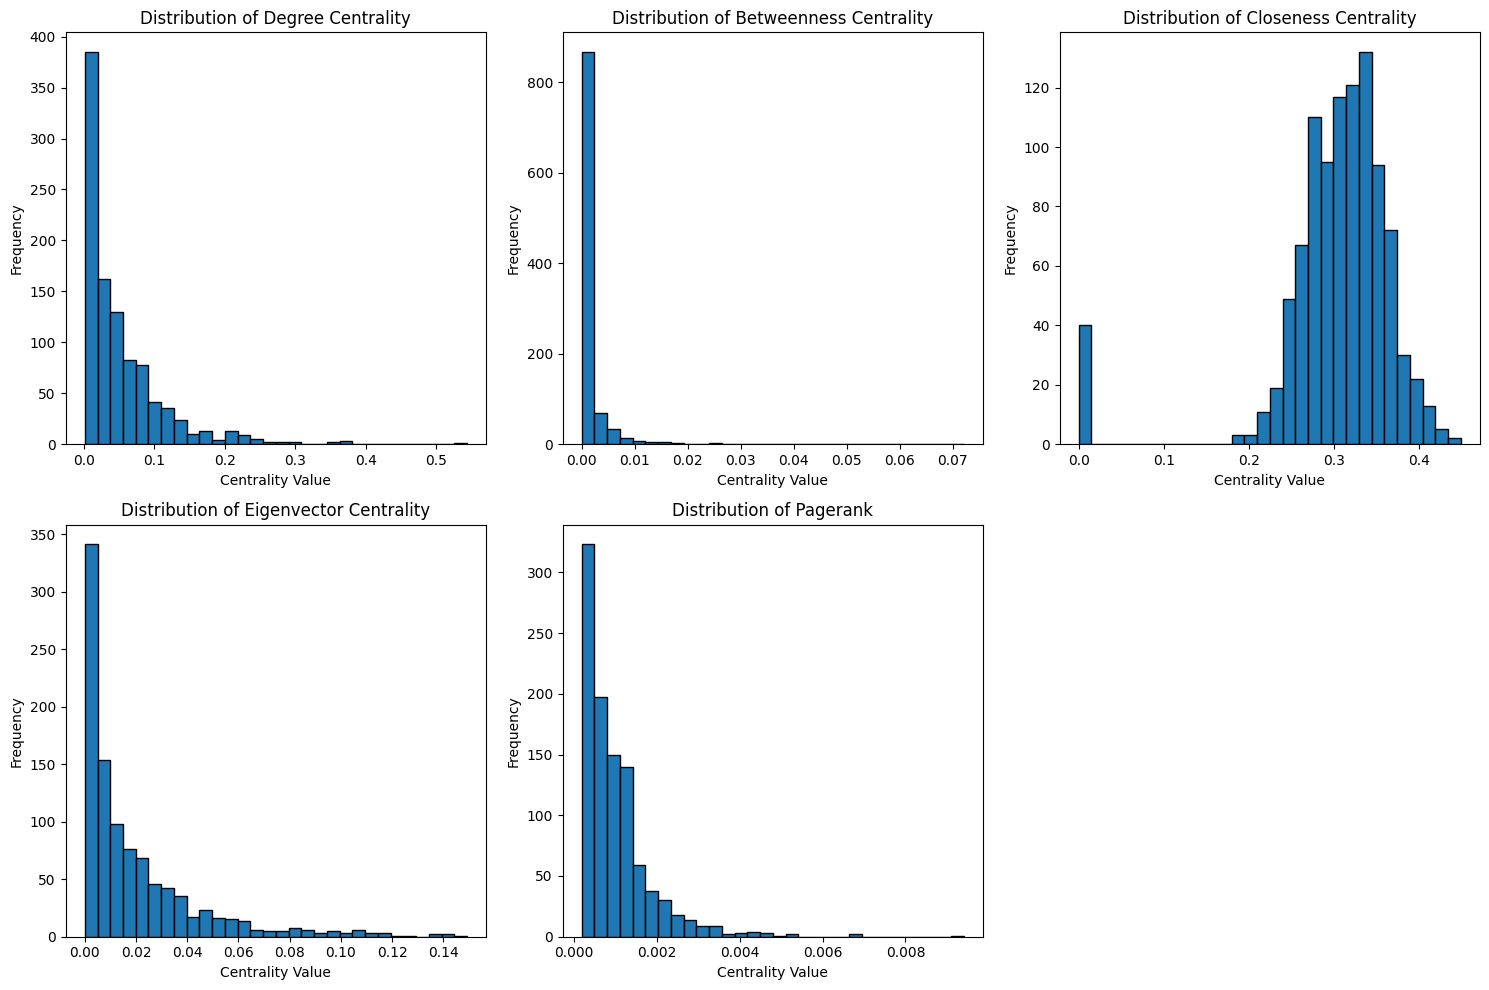

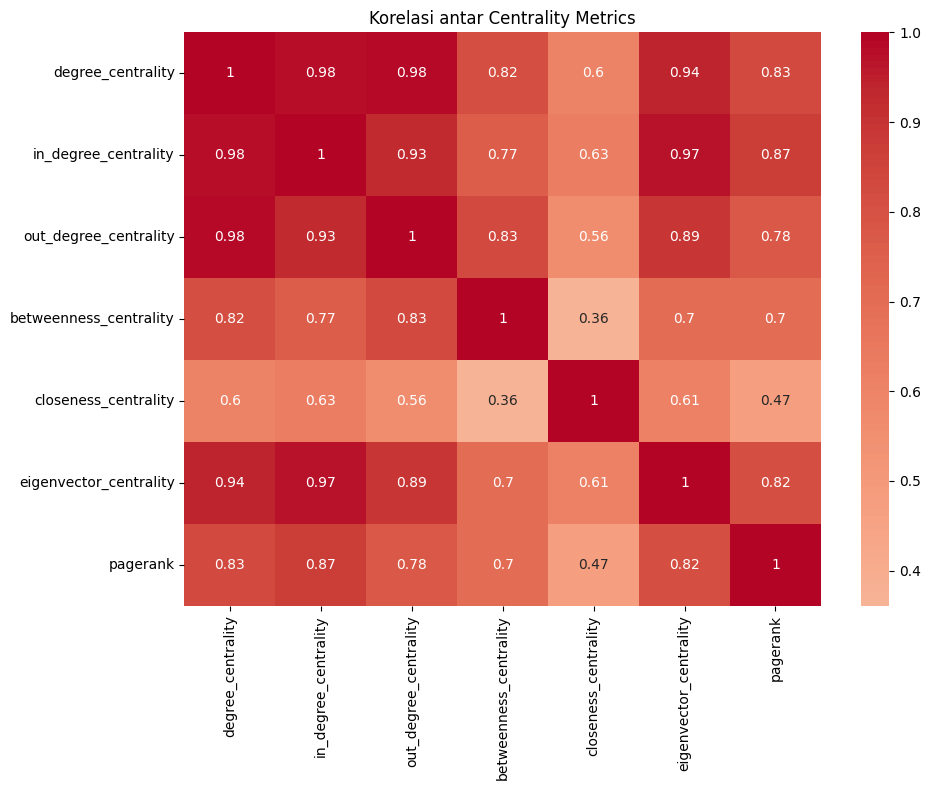


Korelasi antar Centrality Metrics:
                        degree_centrality  in_degree_centrality  \
degree_centrality                1.000000              0.977859   
in_degree_centrality             0.977859              1.000000   
out_degree_centrality            0.984453              0.925899   
betweenness_centrality           0.817429              0.765084   
closeness_centrality             0.601664              0.630339   
eigenvector_centrality           0.943567              0.967713   
pagerank                         0.833682              0.867638   

                        out_degree_centrality  betweenness_centrality  \
degree_centrality                    0.984453                0.817429   
in_degree_centrality                 0.925899                0.765084   
out_degree_centrality                1.000000                0.833465   
betweenness_centrality               0.833465                1.000000   
closeness_centrality                 0.557060                0

In [ ]:
def calculate_centrality_metrics(G):
    # 1. Degree Centrality
    degree_centrality = nx.degree_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)
    
    # 2. Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # 3. Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G)
    
    # 4. Eigenvector Centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=300)
    
    # 5. PageRank
    pagerank = nx.pagerank(G)
    
    return {
        'degree_centrality': degree_centrality,
        'in_degree_centrality': in_degree_centrality,
        'out_degree_centrality': out_degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'pagerank': pagerank
    }

def analyze_top_nodes(centrality_metrics, dept_dict, top_n=10):
    centrality_top_nodes = {}
    
    for metric_name, centrality in centrality_metrics.items():
        # Sort nodes berdasarkan centrality value
        sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Simpan top nodes dengan informasi tambahan
        centrality_top_nodes[metric_name] = [
            {
                'node': node, 
                'value': value, 
                'department': dept_dict.get(node, 'Unknown')
            } for node, value in sorted_nodes
        ]
    
    return centrality_top_nodes

def visualize_centrality_distribution(centrality_metrics):
    plt.figure(figsize=(15, 10))
    
    metrics_to_plot = [
        'degree_centrality', 
        'betweenness_centrality', 
        'closeness_centrality', 
        'eigenvector_centrality', 
        'pagerank'
    ]
    
    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(2, 3, i)
        values = list(centrality_metrics[metric].values())
        
        plt.hist(values, bins=30, edgecolor='black')
        plt.title(f'Distribution of {metric.replace("_", " ").title()}')
        plt.xlabel('Centrality Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def correlation_between_centrality_metrics(centrality_metrics):
    metrics_df = pd.DataFrame(centrality_metrics)
    
    # Hitung korelasi
    correlation_matrix = metrics_df.corr()
    
    # Visualisasi korelasi
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Korelasi antar Centrality Metrics')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Main Execution
centrality_metrics = calculate_centrality_metrics(DG)

# Analisis top nodes
top_nodes = analyze_top_nodes(centrality_metrics, dept_dict)

# Print top nodes untuk setiap metric
for metric, nodes in top_nodes.items():
    print(f"\nTop 10 Nodes - {metric.replace('_', ' ').title()}:")
    for node_info in nodes:
        print(f"Node {node_info['node']}: Value = {node_info['value']:.4f}, Department: {node_info['department']}")

# Visualisasi distribusi
visualize_centrality_distribution(centrality_metrics)

# Korelasi antar metrics
correlation_matrix = correlation_between_centrality_metrics(centrality_metrics)
print("\nKorelasi antar Centrality Metrics:")
print(correlation_matrix)

**Degree Centrality:**
- Sebagian besar node dalam jaringan memiliki koneksi langsung yang terbatas, dengan hanya beberapa node yang berfungsi sebagai "hub" penting. Node 160 dari Department 36 consistently memiliki nilai tertinggi, menunjukkan bahwa node ini memiliki koneksi langsung terbanyak dibandingkan node lainnya. Department 36 mendominasi dalam konektivitas langsung.

**Betweenness Centrality:**
- Beberapa node berperan penting sebagai penghubung strategis dalam jalur komunikasi jaringan. Node-node ini dapat dianggap sebagai "bottleneck," yang memiliki pengaruh signifikan terhadap aliran informasi antar bagian jaringan. Node 160 lagi lagi adalah penghubung penting dalam jaringan.

**Closeness Centrality:**
- Node dengan closeness tinggi cenderung terpusat, memungkinkan mereka menjangkau node lain dengan cepat. Ini menunjukkan bahwa beberapa node berperan sebagai "penyebar informasi" yang efisien. Node 160 sebagai node yang paling terhubung secara efisien ke seluruh jaringan

**Eigenvector Centrality:**
- Beberapa node tidak hanya penting secara langsung tetapi juga terhubung dengan node-node lain yang penting. Ini mengindikasikan bahwa node-node tertentu memiliki pengaruh struktural besar dalam jaringan. Node 160 memiliki pengaruh tinggi karena terhubung dengan node-node lain yang juga berpengaruh.

**PageRank:**
- Node-node tertentu yang memiliki banyak koneksi dengan node-node penting lainnya menonjol sebagai node dengan kepentingan signifikan dalam jaringan. Hal ini relevan dalam jaringan komunikasi seperti email, di mana node dengan PageRank tinggi dapat dianggap sebagai pusat pengaruh. Node 1 dan 130 karena pengaruh struktur jaringan yang lebih luas.

**Average Degree dan Degree Distribution**

Average In-Degree: 25.4438
Average Out-Degree: 25.4438
Total Average Degree: 25.4438


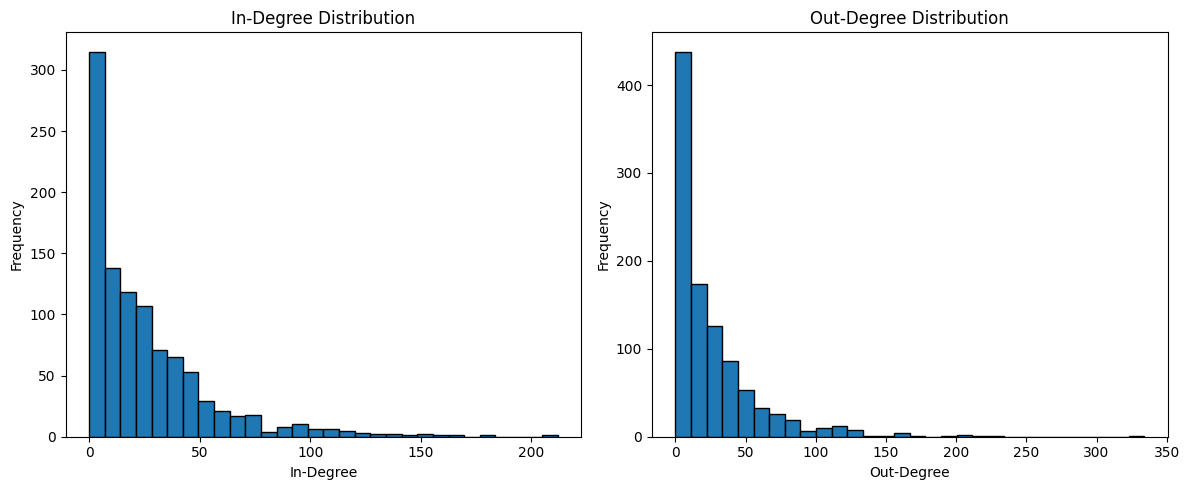

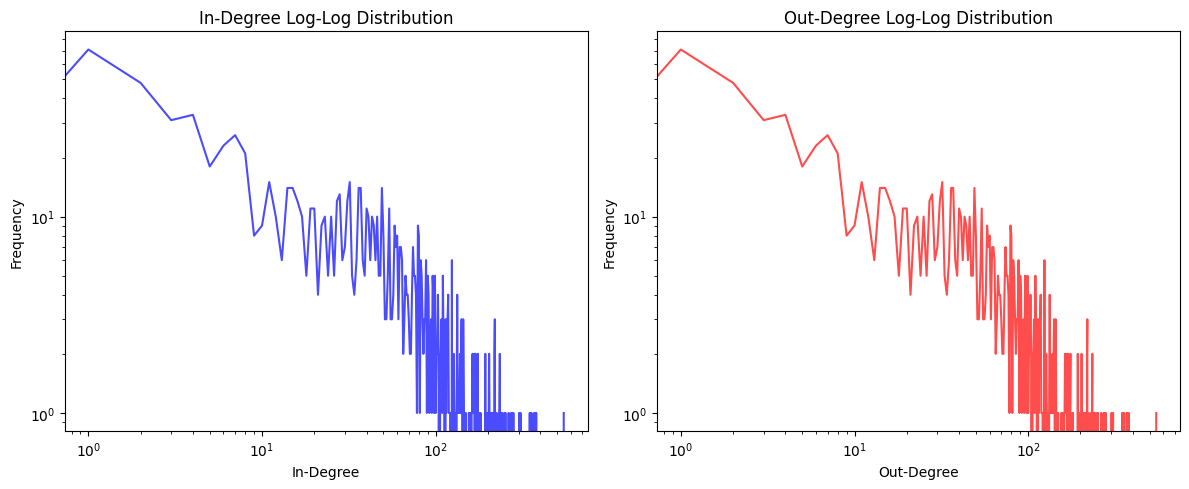


Degree Distribution Statistics:
In-Degree - Min: 0, Max: 212, Median: 18.0
Out-Degree - Min: 0, Max: 334, Median: 15.0


In [10]:
# Calculate in-degree and out-degree
in_degrees = dict(DG.in_degree())
out_degrees = dict(DG.out_degree())

# Average Degree Calculations
avg_in_degree = np.mean(list(in_degrees.values()))
avg_out_degree = np.mean(list(out_degrees.values()))
total_avg_degree = (avg_in_degree + avg_out_degree) / 2

print(f"Average In-Degree: {avg_in_degree:.4f}")
print(f"Average Out-Degree: {avg_out_degree:.4f}")
print(f"Total Average Degree: {total_avg_degree:.4f}")

# Degree Distribution
plt.figure(figsize=(12, 5))

# In-Degree Distribution
plt.subplot(1, 2, 1)
in_degree_values = list(in_degrees.values())
plt.hist(in_degree_values, bins=30, edgecolor='black')
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

# Out-Degree Distribution
plt.subplot(1, 2, 2)
out_degree_values = list(out_degrees.values())
plt.hist(out_degree_values, bins=30, edgecolor='black')
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Log-Log Plot for Degree Distribution
plt.figure(figsize=(12, 5))

# In-Degree Log-Log Plot
plt.subplot(1, 2, 1)
in_degrees_counter = nx.degree_histogram(DG.reverse())
plt.loglog(range(len(in_degrees_counter)), in_degrees_counter, 'b-', alpha=0.7)
plt.title('In-Degree Log-Log Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

# Out-Degree Log-Log Plot
plt.subplot(1, 2, 2)
out_degrees_counter = nx.degree_histogram(DG)
plt.loglog(range(len(out_degrees_counter)), out_degrees_counter, 'r-', alpha=0.7)
plt.title('Out-Degree Log-Log Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Additional Degree Statistics
print("\nDegree Distribution Statistics:")
print(f"In-Degree - Min: {min(in_degrees.values())}, Max: {max(in_degrees.values())}, Median: {np.median(list(in_degrees.values()))}")
print(f"Out-Degree - Min: {min(out_degrees.values())}, Max: {max(out_degrees.values())}, Median: {np.median(list(out_degrees.values()))}")

Dalam jaringan email, distribusi ini menunjukkan hierarki komunikasi, di mana sebagian besar researcher hanya mengirim/menerima beberapa email, sedangkan beberapa peran yang lebih aktif atau memiliki peran lebih tinggi seperti ketua departemen dsb yang memiliki volume komunikasi yang sangat tinggi juga. Average degree 25.4438 yang berarti rata2 node memiliki degree sebanyak 25.

**Clustering Coefficient**

Global Clustering Coefficient: 0.2201
Average Local Clustering Coefficient: 0.3657


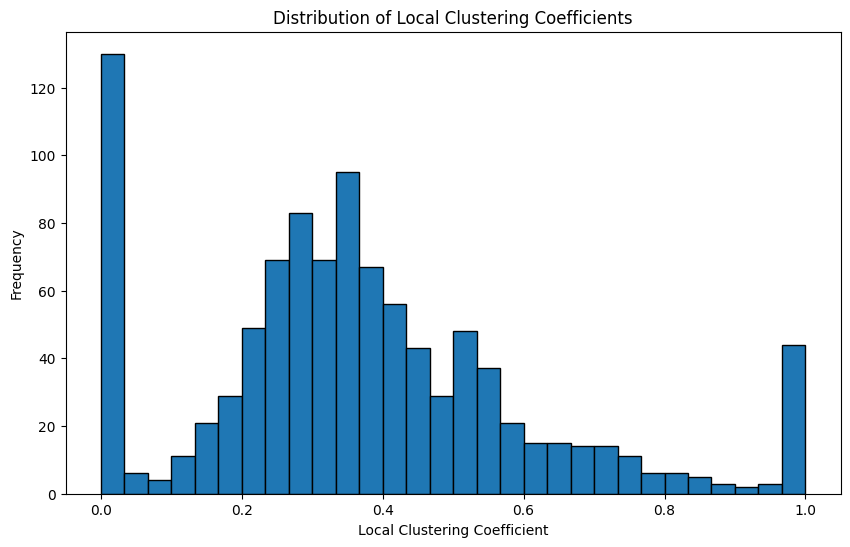


Top 5 Nodes with Highest Local Clustering Coefficients:
Node 382: Clustering Coefficient = 1.0000
Node 383: Clustering Coefficient = 1.0000
Node 398: Clustering Coefficient = 1.0000
Node 439: Clustering Coefficient = 1.0000
Node 456: Clustering Coefficient = 1.0000


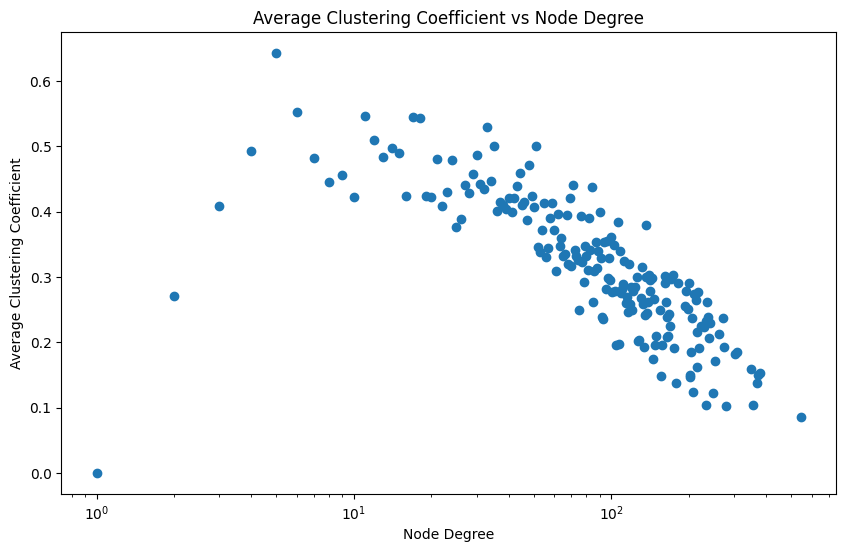


Average Clustering Coefficient by Degree Levels:
Degree 1: Average Clustering Coefficient = 0.0000
Degree 2: Average Clustering Coefficient = 0.2708
Degree 3: Average Clustering Coefficient = 0.4086
Degree 4: Average Clustering Coefficient = 0.4924
Degree 5: Average Clustering Coefficient = 0.6426
Degree 6: Average Clustering Coefficient = 0.5529
Degree 7: Average Clustering Coefficient = 0.4828
Degree 8: Average Clustering Coefficient = 0.4461
Degree 9: Average Clustering Coefficient = 0.4555
Degree 10: Average Clustering Coefficient = 0.4219


In [11]:
# Clustering Coefficient Analysis

# 1. Global Clustering Coefficient (Transitivity)
global_clustering_coeff = nx.transitivity(DG)
print(f"Global Clustering Coefficient: {global_clustering_coeff:.4f}")

# 2. Average Local Clustering Coefficient
local_clustering_coeffs = nx.clustering(DG)
avg_local_clustering_coeff = np.mean(list(local_clustering_coeffs.values()))
print(f"Average Local Clustering Coefficient: {avg_local_clustering_coeff:.4f}")

# 3. Visualization of Local Clustering Coefficients
plt.figure(figsize=(10, 6))
plt.hist(list(local_clustering_coeffs.values()), bins=30, edgecolor='black')
plt.title('Distribution of Local Clustering Coefficients')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

# 4. Top Nodes by Local Clustering Coefficient
print("\nTop 5 Nodes with Highest Local Clustering Coefficients:")
top_clustering_nodes = sorted(local_clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[:5]
for node, coeff in top_clustering_nodes:
    print(f"Node {node}: Clustering Coefficient = {coeff:.4f}")

# 5. Clustering Coefficient by Degree
def analyze_clustering_by_degree(G, clustering_coeffs):
    degrees = dict(G.degree())
    degree_clusters = {}
    
    for node, cluster_coeff in clustering_coeffs.items():
        degree = degrees[node]
        if degree not in degree_clusters:
            degree_clusters[degree] = []
        degree_clusters[degree].append(cluster_coeff)
    
    avg_clusters_by_degree = {d: np.mean(coeffs) for d, coeffs in degree_clusters.items()}
    
    plt.figure(figsize=(10, 6))
    plt.scatter(list(avg_clusters_by_degree.keys()), list(avg_clusters_by_degree.values()))
    plt.title('Average Clustering Coefficient vs Node Degree')
    plt.xlabel('Node Degree')
    plt.ylabel('Average Clustering Coefficient')
    plt.xscale('log')
    plt.show()
    
    return avg_clusters_by_degree

clustering_by_degree = analyze_clustering_by_degree(DG, local_clustering_coeffs)
print("\nAverage Clustering Coefficient by Degree Levels:")
for degree, avg_cluster in sorted(clustering_by_degree.items())[:10]:
    print(f"Degree {degree}: Average Clustering Coefficient = {avg_cluster:.4f}")

**Clustering Coefficient:**

- Global Clustering Coefficient (22.01%): 22% dari triplet yang ada dalam jaringan membentuk segitiga. Ini menunjukkan bahwa jaringan tersebut memiliki tingkat keterhubungan yang cukup tinggi, tetapi tidak semua triplet saling terhubung.
- Average Local Clustering Coefficient (36.57%): 36.57% tetangga dari setiap node di jaringan ini saling terhubung (membentuk segitiga).
- Node dengan Clustering Coefficient Maksimal (1.0000): Beberapa node memiliki hubungan sempurna antara tetangganya, membentuk komunitas lokal penuh (clique).

**Diameter & Average Path Length**

Network Diameter (Weak Connected Component): 7
Average Path Length (Weak Connected Component): 2.5869


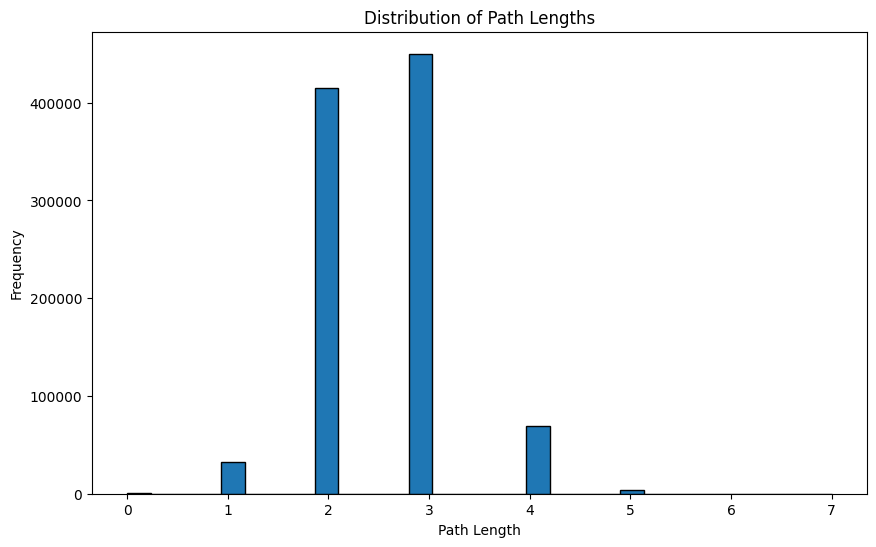


Number of Weakly Connected Components: 20
Size of Largest Weakly Connected Component: 986 nodes


In [12]:
# Diameter & Average Path Length Analysis

# 1. Find the largest weakly connected component
largest_wcc = max(nx.weakly_connected_components(DG), key=len)
wcc_subgraph = DG.subgraph(largest_wcc)

# 2. Convert to undirected graph for path length calculations
UG = wcc_subgraph.to_undirected()

# 3. Diameter of the Weak Connected Component
wcc_diameter = nx.diameter(UG)
print(f"Network Diameter (Weak Connected Component): {wcc_diameter}")

# 4. Average Path Length of the Weak Connected Component
avg_path_length = nx.average_shortest_path_length(UG)
print(f"Average Path Length (Weak Connected Component): {avg_path_length:.4f}")

# 5. Visualization of Path Length Distribution
path_lengths = dict(nx.all_pairs_shortest_path_length(UG))

# Flatten path lengths
all_path_lengths = []
for node_paths in path_lengths.values():
    all_path_lengths.extend(list(node_paths.values()))

plt.figure(figsize=(10, 6))
plt.hist(all_path_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

# Additional network connectivity information
print(f"\nNumber of Weakly Connected Components: {nx.number_weakly_connected_components(DG)}")
print(f"Size of Largest Weakly Connected Component: {len(largest_wcc)} nodes")

- Setiap WCC merupakan kelompok node yang terisolasi secara topologi, graf tersebut dapat dipisah menjadi 20 subgraf yang tidak saling terhubung satu sama lain
-  Komponen terhubung lemah terbesar (WCC terbesar) mencakup 986 node
- Diameter terpanjang 7 dan average path length 2.5

Strongly Connected Component Analysis:
Number of Strongly Connected Components: 203
Size of Largest Strongly Connected Component: 803 nodes
Directed Diameter (Largest Strongly Connected Component): 6
Average Directed Path Length: 2.5475


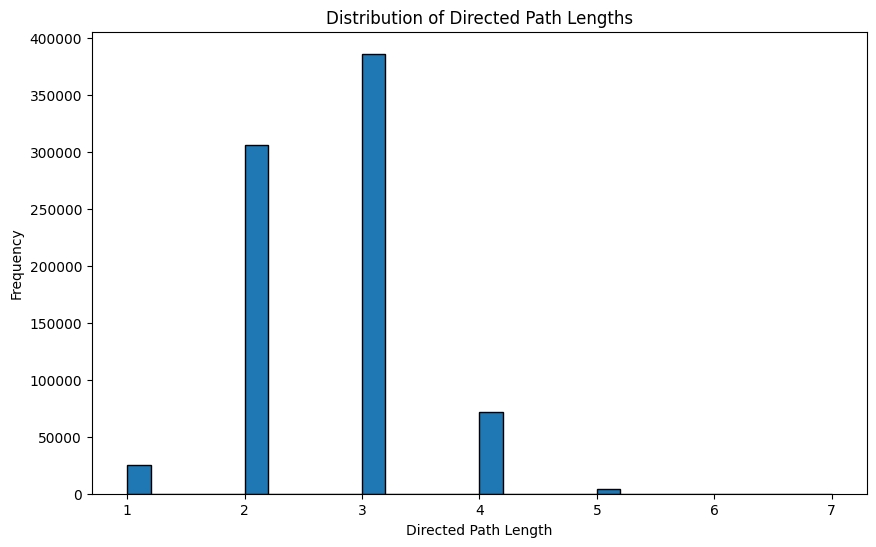


Directed Path Length Statistics:


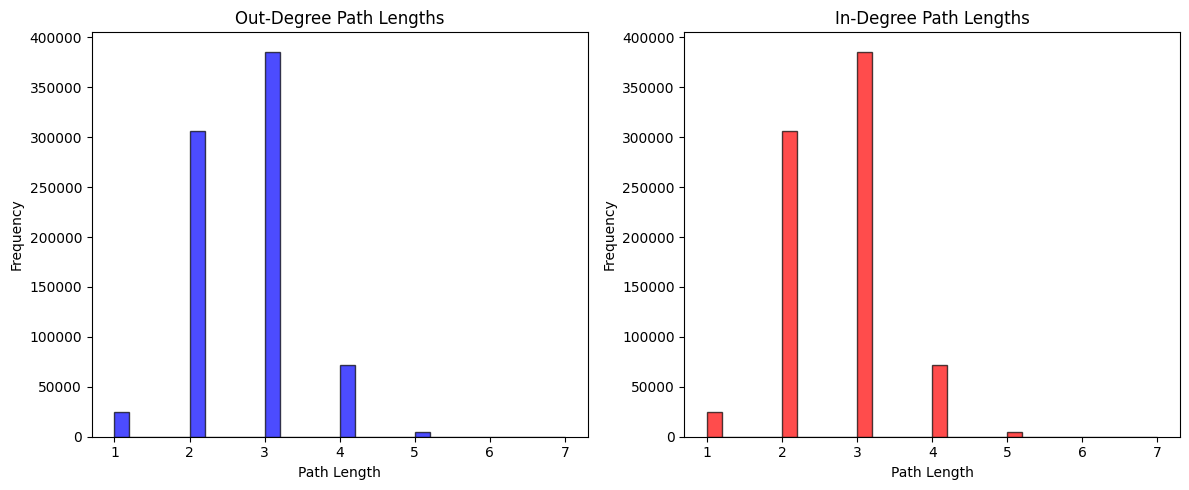

In [13]:
# Detailed Directed Network Analysis
def analyze_directed_network_paths(DG):
    # 1. Strongly Connected Components
    strongly_connected_comps = list(nx.strongly_connected_components(DG))
    largest_scc = max(strongly_connected_comps, key=len)
    scc_subgraph = DG.subgraph(largest_scc)
    
    print("Strongly Connected Component Analysis:")
    print(f"Number of Strongly Connected Components: {len(strongly_connected_comps)}")
    print(f"Size of Largest Strongly Connected Component: {len(largest_scc)} nodes")
    
    # 2. Directed Path Calculations
    # Compute directed path lengths for the largest strongly connected component
    try:
        # Diameter (longest shortest path)
        scc_diameter = nx.diameter(scc_subgraph)
        print(f"Directed Diameter (Largest Strongly Connected Component): {scc_diameter}")
    except nx.NetworkXError:
        print("Cannot compute diameter for strongly connected component")
    
    # 3. Average Directed Path Length
    try:
        avg_directed_path_length = nx.average_shortest_path_length(scc_subgraph)
        print(f"Average Directed Path Length: {avg_directed_path_length:.4f}")
    except nx.NetworkXError:
        print("Cannot compute average path length for strongly connected component")
    
    # 4. Generalized Path Length Analysis
    def compute_directed_path_lengths(G):
        path_lengths = []
        for source in G.nodes():
            for target in G.nodes():
                if source != target:
                    try:
                        path_length = nx.shortest_path_length(G, source, target)
                        path_lengths.append(path_length)
                    except nx.NetworkXNoPath:
                        # If no path exists, we skip
                        continue
        return path_lengths
    
    # Compute path lengths for the entire graph
    all_path_lengths = compute_directed_path_lengths(DG)
    
    # 5. Visualization of Directed Path Lengths
    plt.figure(figsize=(10, 6))
    plt.hist(all_path_lengths, bins=30, edgecolor='black')
    plt.title('Distribution of Directed Path Lengths')
    plt.xlabel('Directed Path Length')
    plt.ylabel('Frequency')
    plt.show()
    
    # 6. Additional Path-related Metrics
    print("\nDirected Path Length Statistics:")
    
    # 7. In-Degree and Out-Degree Path Analysis
    in_degree_paths = []
    out_degree_paths = []
    
    for node in DG.nodes():
        # Paths from this node to others (out-degree paths)
        out_paths = [len(nx.shortest_path(DG, node, target)) - 1 
                     for target in DG.nodes() 
                     if node != target and nx.has_path(DG, node, target)]
        
        # Paths to this node from others (in-degree paths)
        in_paths = [len(nx.shortest_path(DG, source, node)) - 1 
                    for source in DG.nodes() 
                    if node != source and nx.has_path(DG, source, node)]
        
        out_degree_paths.extend(out_paths)
        in_degree_paths.extend(in_paths)
    
    # Visualize In-Degree and Out-Degree Path Distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(out_degree_paths, bins=30, edgecolor='black', color='blue', alpha=0.7)
    plt.title('Out-Degree Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(in_degree_paths, bins=30, edgecolor='black', color='red', alpha=0.7)
    plt.title('In-Degree Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'strongly_connected_components': len(strongly_connected_comps),
        'largest_scc_size': len(largest_scc),
        'path_lengths': all_path_lengths
    }

# Run the analysis
network_metrics = analyze_directed_network_paths(DG)

Jaringan email-Eu-core menunjukkan bahwa mayoritas node (803 dari 1005) berada dalam satu kelompok besar yang saling terhubung secara kuat (Largest SCC). Diameter kecil (6) dan rata-rata panjang jalur pendek (2.55) mengindikasikan bahwa jaringan ini efisien dalam menghubungkan pengirim dan penerima pesan, meskipun terdapat 203 kelompok terpisah dalam graf.

**Scaling Exponent**

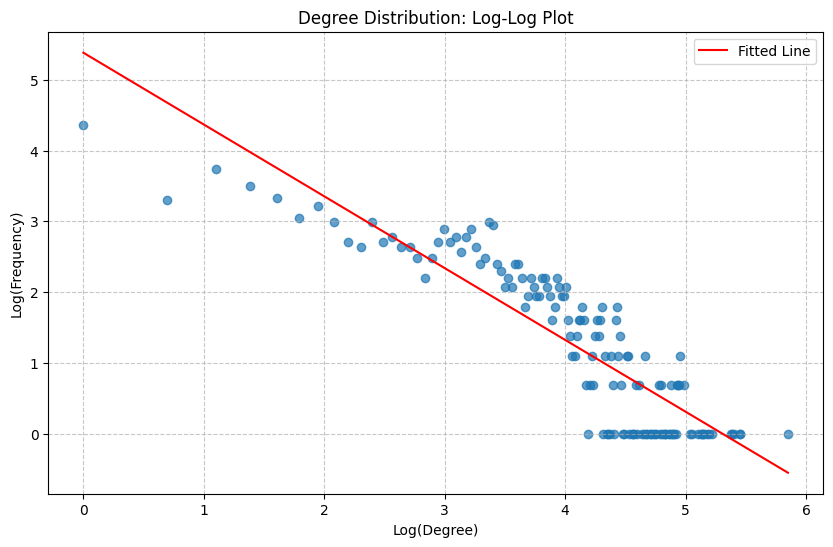


Scaling Exponent (Power Law Analysis):
Scaling Exponent: 1.0145
R-squared: 0.7899


In [14]:
def analyze_scaling_exponent(G):
    def calculate_scaling_exponent(degrees):
        # Fit power law distribution
        degree_freq = np.bincount(degrees)
        log_degrees = np.log(np.nonzero(degree_freq)[0])
        log_freq = np.log(degree_freq[degree_freq.nonzero()])
        
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_freq)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(log_degrees, log_freq, alpha=0.7)
        plt.plot(log_degrees, intercept + slope * log_degrees, 'r', label='Fitted Line')
        plt.title('Degree Distribution: Log-Log Plot')
        plt.xlabel('Log(Degree)')
        plt.ylabel('Log(Frequency)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
        return -slope, r_value**2

    degrees = [d for n, d in G.degree()]
    scaling_exponent, r_squared = calculate_scaling_exponent(degrees)
    print("\nScaling Exponent (Power Law Analysis):")
    print(f"Scaling Exponent: {scaling_exponent:.4f}")
    print(f"R-squared: {r_squared:.4f}")
    
    return scaling_exponent, r_squared

# Run scaling exponent analysis
scaling_exponent, r_squared = analyze_scaling_exponent(UG)

**Scaling Exponent:**
- Nilai eksponen ini mengindikasikan bahwa graf memiliki karakteristik hampir linear dan distribusi derajat yang mengikuti power-law. di mana sebagian besar node memiliki derajat kecil, sementara beberapa node memiliki derajat sangat besar.

**Assortativity**

In [15]:
def analyze_assortativity(G):
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    print("\nAssortativity Metrics:")
    print(f"Degree Assortativity: {degree_assortativity:.4f}")
    return degree_assortativity

# Run assortativity analysis
degree_assortativity = analyze_assortativity(UG)

def analyze_assortativity_by_department(G):
    # Menghitung assortativitas berdasarkan departemen
    department_assortativity = nx.attribute_assortativity_coefficient(G, 'department')
    
    print("\nAssortativity Metrics by Department:")
    print(f"Department Assortativity: {department_assortativity:.4f}")
    
    return department_assortativity

# Run assortativity analysis by department
department_assortativity = analyze_assortativity_by_department(DG)


Assortativity Metrics:
Degree Assortativity: -0.0119

Assortativity Metrics by Department:
Department Assortativity: 0.3314


**Degree Assortativity (-0.0119):** 
- Sangat mendekati nol, menunjukkan bahwa tidak ada pola signifikan antara derajat node yang terhubung. Ini menunjukkan hubungan acak, yang khas dalam jaringan komunikasi. (Neutral Network)

**Department Assortativity (0.3314):** 
- Node cenderung lebih sering terhubung dengan node lain dari departemen yang sama, yang masuk akal dalam konteks jaringan komunikasi seperti email.
(each node links only to node with the same degree) (mendekati Assortative)

**Modularity**

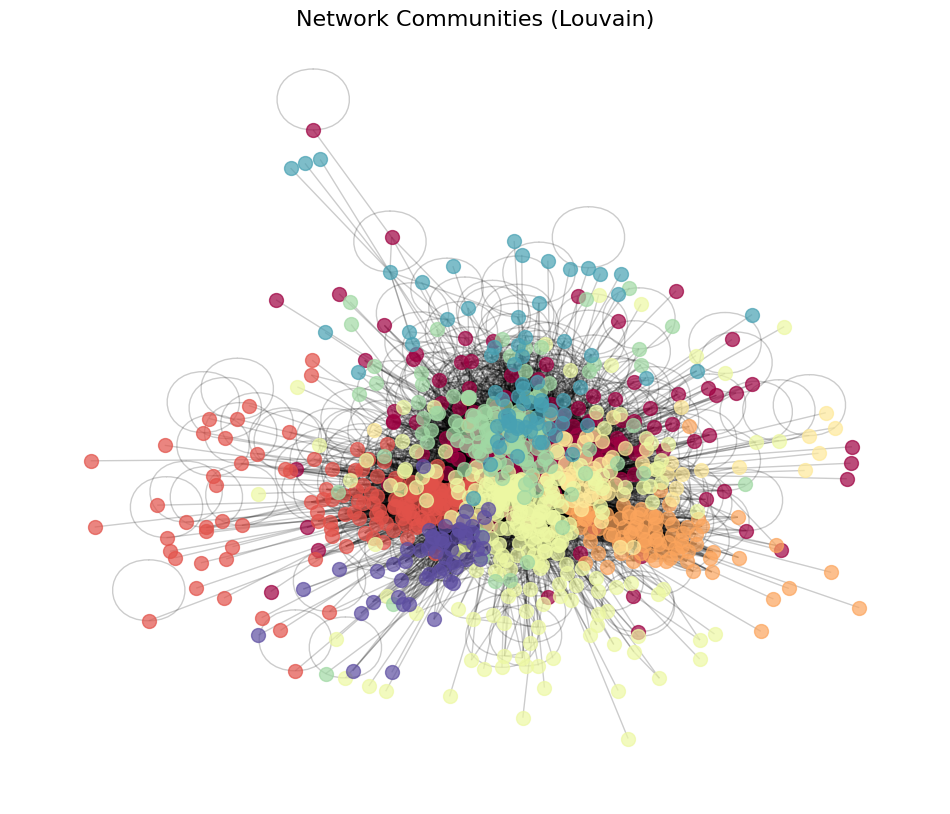


3. Modularity Analysis:
Modularity: 0.4300

Community Size Distribution:
Community 4: 255 nodes
Community 0: 168 nodes
Community 1: 146 nodes
Community 5: 129 nodes
Community 2: 92 nodes
Community 6: 74 nodes
Community 3: 67 nodes
Community 7: 55 nodes


In [16]:
def analyze_modularity(G):
    def compute_modularity(G):
        # Use Louvain method for community detection
        partition = community_louvain.best_partition(G.to_undirected())
        
        # Compute modularity
        modularity = community_louvain.modularity(partition, G.to_undirected())
        
        # Visualize communities
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G, seed=42)
        
        # Color nodes by community
        communities = set(partition.values())
        colors = plt.cm.get_cmap('Spectral', len(communities))(np.linspace(0, 1, len(communities)))
        
        for i, comm_color in zip(communities, colors):
            community_nodes = [n for n in G.nodes() if partition[n] == i]
            nx.draw_networkx_nodes(G, pos, nodelist=community_nodes, node_color=[comm_color], alpha=0.7, node_size=100)
        
        nx.draw_networkx_edges(G, pos, alpha=0.2)
        
        plt.title('Network Communities (Louvain)', fontsize=16)
        plt.axis('off')
        plt.show()
        
        return modularity, partition

    modularity, partition = compute_modularity(G)
    print("\n3. Modularity Analysis:")
    print(f"Modularity: {modularity:.4f}")
    
    # Community size distribution
    community_sizes = {}
    for community in set(partition.values()):
        community_sizes[community] = sum(1 for p in partition.values() if p == community)
    
    print("\nCommunity Size Distribution:")
    for comm, size in sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"Community {comm}: {size} nodes")

# Menjalankan analisis modularitas
modularity_result = analyze_modularity(UG)

**Modularity dan Komunitas:**
- Modularity (0.4300) berada dalam kisaran sedang, menunjukkan bahwa jaringan memiliki struktur komunitas yang cukup baik, tetapi tidak sepenuhnya terisolasi.
- Terdapat komunitas besar dan kecil, dengan komunitas terbesar mencakup 255 node. Hal ini mencerminkan pola interaksi yang terpusat dalam kelompok tertentu, kemungkinan besar sesuai dengan struktur organisasi.

**Kesimpulan**

Jaringan ini memiliki sifat khas jaringan komunikasi: efisien dalam konektivitas global (panjang jalur pendek), terorganisir dalam komunitas (modularity signifikan), tetapi tetap cukup acak dalam pola koneksi antar node (degree assortativity rendah). Jaringan ini menunjukkan pola interaksi lokal yang kuat di dalam kelompok tertentu (misalnya, departemen), sementara beberapa node memainkan peran penting sebagai hub atau penghubung antar komunitas.

Temuan

- Department Assortativity (0.3162): Node lebih sering berkomunikasi dengan rekan dari departemen yang sama, menunjukkan pola komunikasi internal yang khas di institusi riset.

- Scaling Exponent (1.1358): Jaringan mengikuti distribusi power-law, mengindikasikan jaringan skala bebas dengan sebagian besar node memiliki sedikit koneksi, tetapi terdapat beberapa node yang sangat terhubung (hub penting).

- Modularity (0.4324): Jaringan memiliki struktur komunitas yang signifikan, dengan komunikasi yang lebih sering terjadi dalam komunitas tertentu, mencerminkan keberadaan kelompok kerja atau departemen yang kuat di dalam institusi.

- Komponen Terhubung Besar (986 node): Sebagian besar node berada dalam satu kelompok besar, menunjukkan bahwa meskipun ada komunitas kecil, sebagian besar komunikasi terjadi dalam satu bagian besar dari jaringan.